# DCGAN on Street View House Numbers Images

In this notebook, I'm going to include my work on training a DSGAN on the [Street View House Numbers (SVHN) dataset](http://ufldl.stanford.edu/housenumbers/)
. The images in this dataset are collected from Google street view. The goal is to create a DCGAN that can hopefully generate new, realistic-looking images of house numbers. 

Here are the steps:
* Load and pre-process house numbers dataset
* Defining  adversarial discriminator and generator networks
* Training both networks
* Observing some samples generated by the generator.

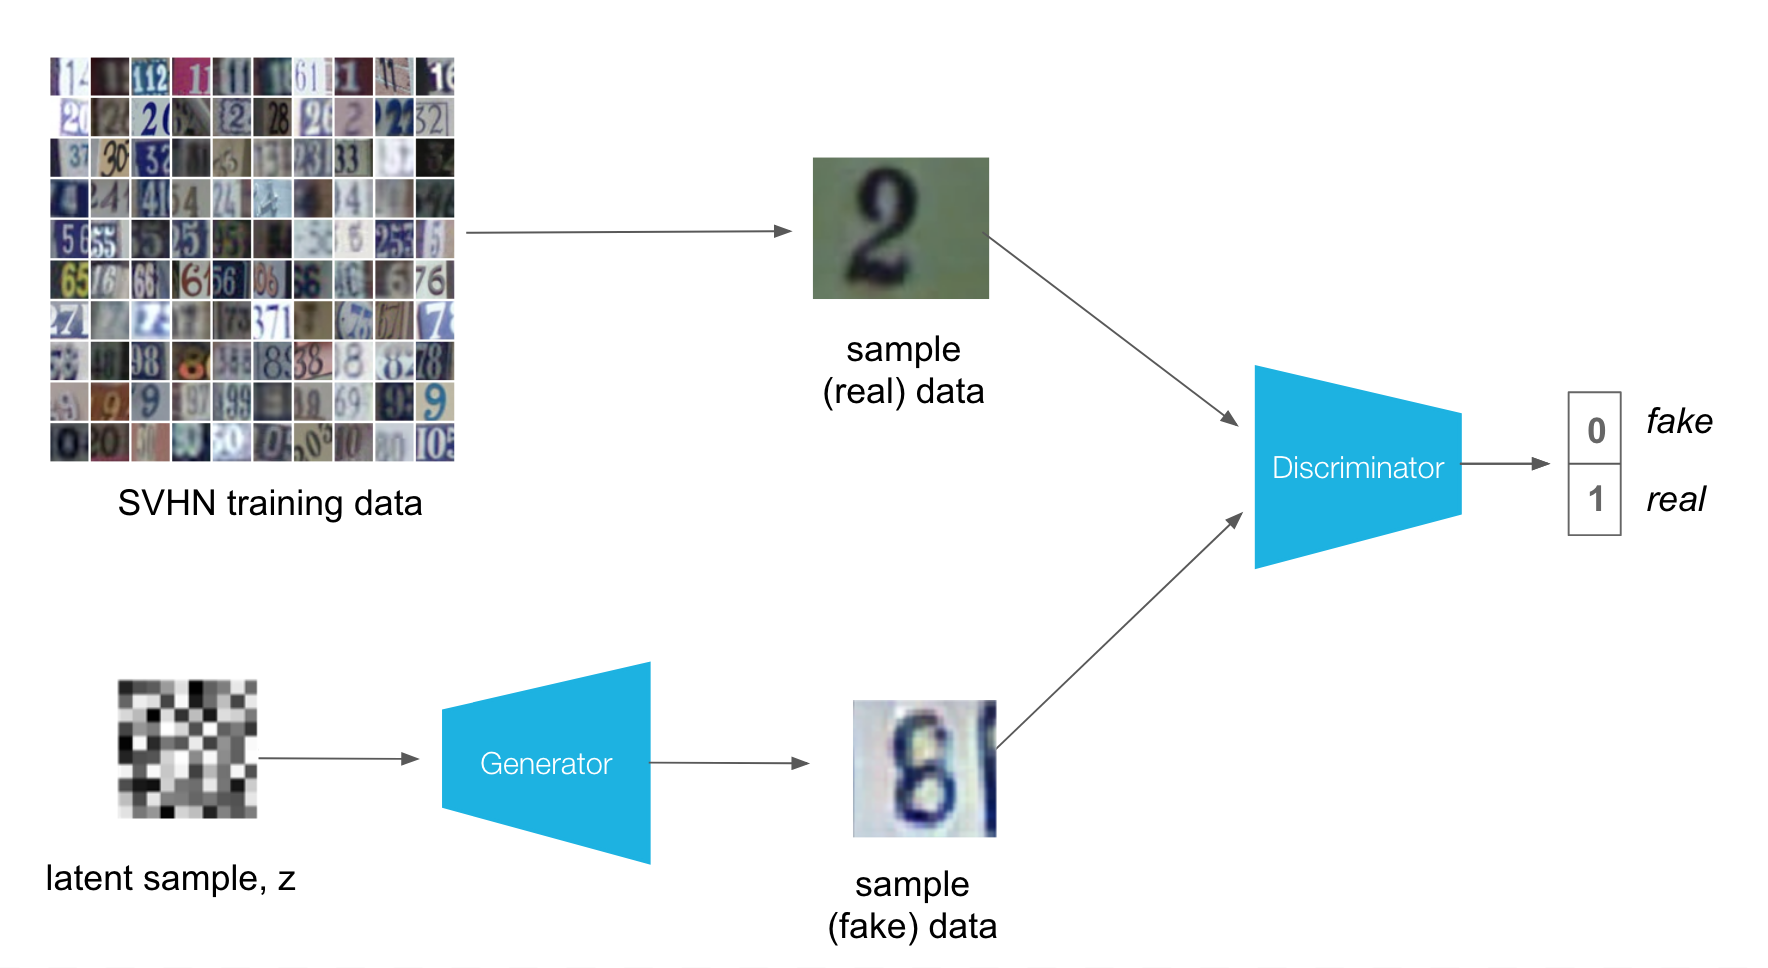

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl

%matplotlib inline

In [2]:
########################################
############## SETTINGS ################
########################################

#Data Loader
batch_size = 128
num_workers = 0

### Loading SVHN Data

In [3]:
import torch
from torchvision import datasets
from torchvision import transforms

#Tensor transform
transform = transforms.ToTensor()

#SVHN training datasets
svhn_train = datasets.SVHN(root = 'data/', split='train', download=True, transform=transform)

#Building Data Loader
train_loader = torch.utils.data.DataLoader(dataset=svhn_train, 
                                           batch_size=batch_size, 
                                           shuffle=True, 
                                           num_workers=num_workers)

Using downloaded and verified file: data/train_32x32.mat


### Visualizing Sample Data

Each image is 32*32 with 3 channels (RGB). 

In [4]:
# getting one batch of images
dataiter = iter(train_loader)
images, labels = dataiter.next()

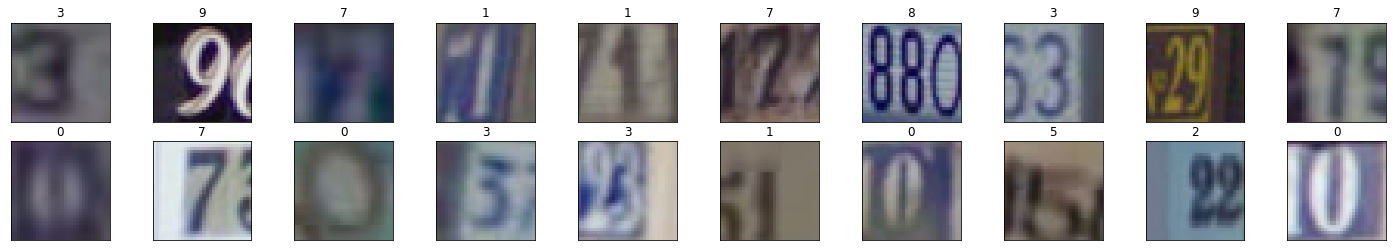

In [5]:
fig = plt.figure(figsize = (25,4))
plot_size = 20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, plot_size/2, idx+1, xticks = [], yticks=[])
    ax.imshow(np.transpose(images[idx], (1,2,0)))
    ax.set_title(str(labels[idx].item()))

Pixel valuse in our training images are between 0 and 1. As the generator final activation layer would use tanh, which generates values in (-1, 1), we'll have to re-scale pixel valuse of training images to (-1,1)

In [6]:
images[3].min(), images[3].max()

(tensor(0.2039), tensor(0.6588))

In [7]:
def scale(x, feature_range=(-1,1)):
    return x*(feature_range[1] - feature_range[0]) + feature_range[0]

In [8]:
scaled_img = scale(images[3])

print(scaled_img.min(), scaled_img.max())

tensor(-0.5922) tensor(0.3176)


## Discriminator

The Discriminator in DCGANs is similar to CNN classifiers, except that no maxpooling layer is normally used. Instead, the downsampling is done using the regular conv layers that have a stride of 2.

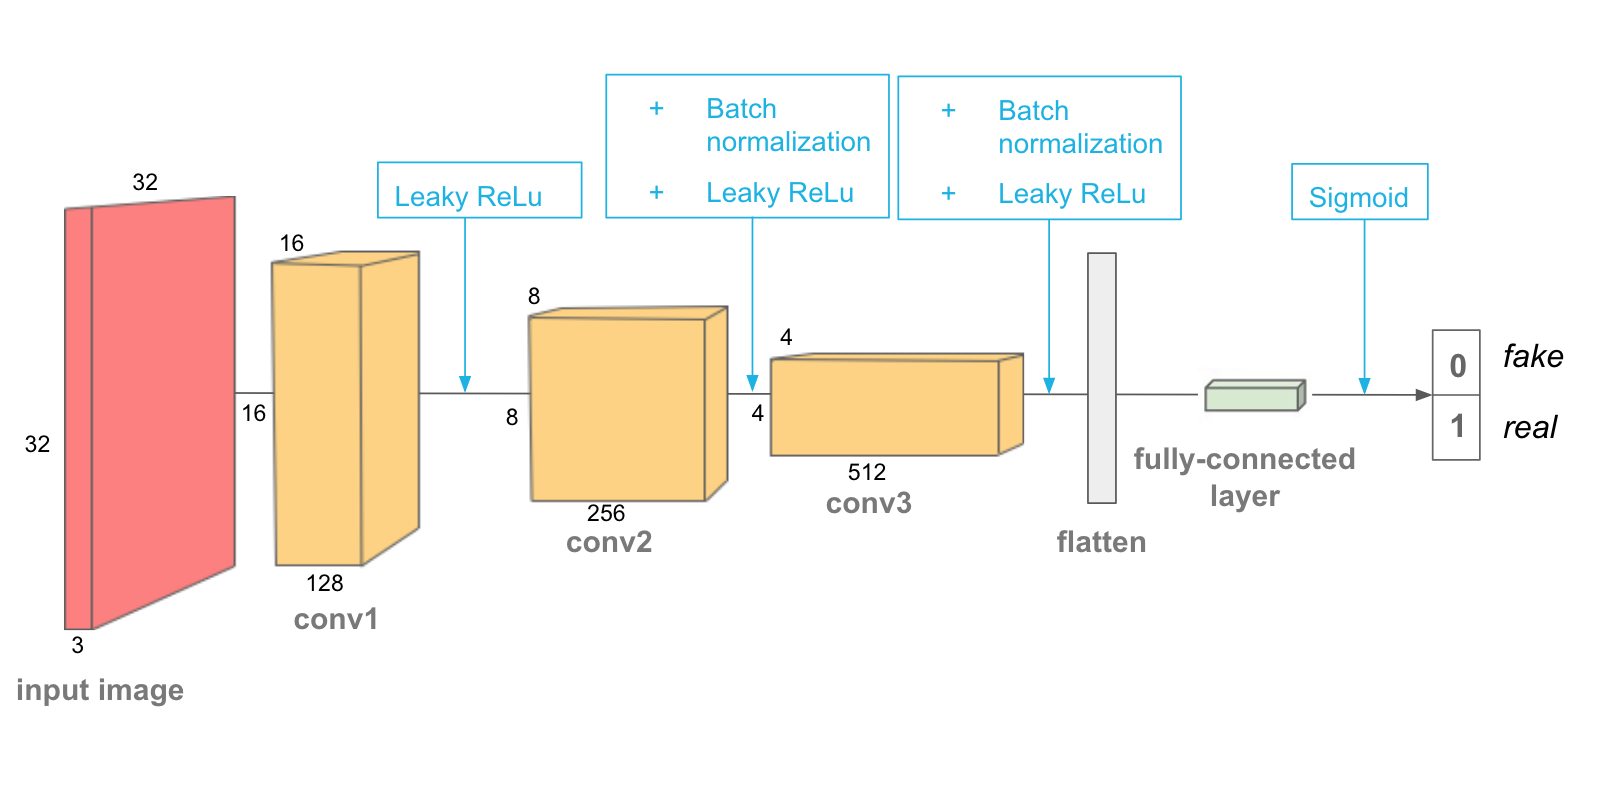

### Helper conv Function
In general, each layer should look like something like *convolution > batch_norm > leaky ReLU*. We can define a function to put these layers together. We can create this function using PyTorch's [Sequential container](https://pytorch.org/docs/stable/nn.html#sequential), which takes in a list of layers and creates layers according to the orther that they are passed in to the Sequential constructor

In [9]:
import torch.nn as nn
import torch.nn.functional as F

def conv(in_channels, out_channels, kernel_size=4, stride=2, padding=1, batch_norm=True):
    layers = []
    conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
    
    layers.append(conv_layer)
    
    if batch_norm:
        layers.append(nn.BatchNorm2d(out_channels))
        
    return nn.Sequential(*layers)

In [10]:
class Discriminator(nn.Module):
    def __init__(self, conv_dim = 32):
        super(Discriminator, self).__init__()
        
        self.conv_dim = conv_dim
        
        self.conv1 = conv(3, conv_dim, batch_norm=False)
        self.conv2 = conv(conv_dim, conv_dim*2)
        self.conv3 = conv(conv_dim*2, conv_dim*4)
        
        self.fc = nn.Linear(conv_dim*4*4*4, 1)
        
    def forward(self,x):
        x = nn.LeakyReLU(self.conv1(x), 0.2)
        x = nn.LeakyReLU(self.conv2(x), 0.2)
        x = nn.LeakyReLU(self.conv3(x), 0.2)
        
        x = x.view(-1, self.conv_dim*4*4*4)
        
        out = self.fc(x)
        
        return out